--- 분석 대상 시계열 3 (복합 이상치): [10, 11, 12, 10, 9, 110, 12, 10, 11, 13, 10, 12, 50, 55, 52, 53, 51, 54, 10, 12, 11, 2, 13, 10] ---
LLM 응답이 유효한 JSON 형식이 아닙니다. 응답 내용:
```json
{
  "briefExplanation": {
    "step1_global": "전체 추세 분석 결과, 특정 구간에서 급격한 값의 변화가 관찰됨",
    "step2_local": "국소적 세그먼트 분석 결과, 인덱스 5, 12-17에서 비정상적으로 높은 값 탐지",
    "step3_reassess": "재검토 및 최종 확인 결과, 인덱스 5, 12-17의 값이 실제 이상 징후로 확인됨"
  },
  "is_anomaly": true,
  "anomalies": [5, 12, 13, 14, 15, 16, 17],
  "anomaly_type": "TransientLevelShiftUp",
  "reason_for_anomaly_type": "인덱스 12부터 17까지 연속적으로 높은 값을 유지하다가 인덱스 18에서 원래 수준으로 돌아옴",
  "alarm_level": "Important",
  "reason_for_alarm_level": "일시적 수준 상승이 관찰되었으나 즉각적인 조치가 필요하지는 않음"
}
```

--- Time Series 3 (Mixed Anomalies) 분석 결과 ---

[LLM 분석 요약]
  이상 징후 발견 여부: 예
  탐지된 이상 징후 인덱스 (원본 데이터 기준): [5, 12, 13, 14, 15, 16, 17]
  이상 징후 유형: Unknown (JSON Parse Error)
  유형 판단 근거: LLM 응답 파싱 실패
  경보 수준: Unknown (JSON Parse Error)
  경보 수준 판단 근거: LLM 응답 파싱 실패

[상세 설명 (LLM 제공)]
  1단계 (전체 추세): JSON 파싱 실패
 

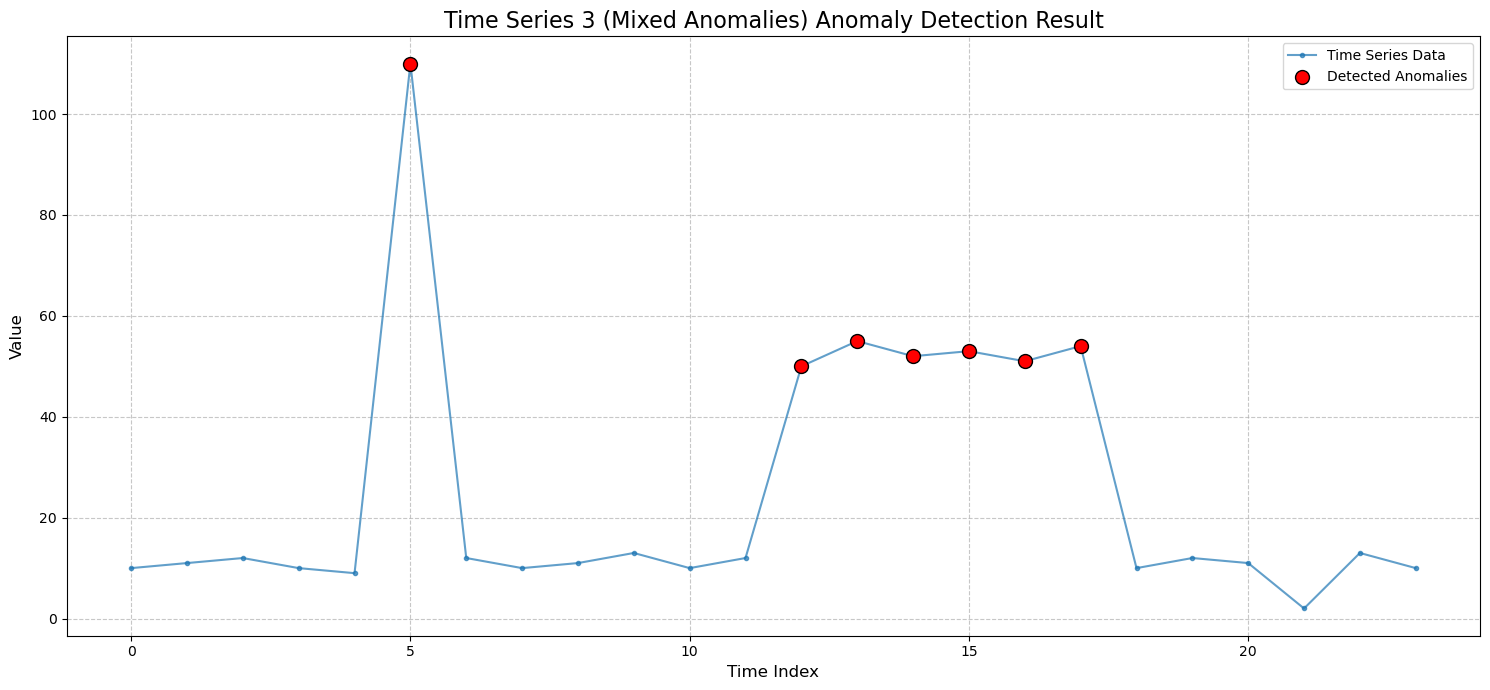

In [1]:
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import json
import requests
import matplotlib.pyplot as plt

# --- (이전 코드의 1. 데이터 전처리, 2. 유사 시계열 검색 부분은 동일) ---
# --- 1. 데이터 전처리 ---
def rescale_series(series, alpha_percentile=95, beta=0.05):
    if not series:
        return [], 0, 0
    series_np = np.array(series)
    a = np.percentile(series_np, alpha_percentile)
    if a == 0: a = 1
    min_xt = np.percentile(series_np, 1)
    max_xt = np.percentile(series_np, 99)
    if max_xt == min_xt: b = min_xt
    else: b = min_xt - beta * (max_xt - min_xt)
    rescaled = [round(1000 * (x - b) / a) if a != 0 else 0 for x in series]
    return rescaled, a, b

def index_series(series):
    return [{"index": i, "value": val} for i, val in enumerate(series)]

def series_to_string(indexed_series):
    return "\n".join([f"인덱스 {item['index']}: 값 {item['value']}" for item in indexed_series])

# --- 2. 유사 시계열 검색 (ICL) ---
def find_similar_series(target_series, historical_normal_db, historical_anomaly_db, k_normal=1, k_anomaly=2):
    similar_normal = []
    similar_anomaly = []
    target_series_np = np.array(target_series).reshape(-1, 1)

    for normal_example in historical_normal_db:
        distance, _ = fastdtw(target_series_np, np.array(normal_example['data']).reshape(-1, 1), dist=euclidean)
        similar_normal.append({'data': normal_example['data'], 'distance': distance, 'description': normal_example.get('description', '정상 데이터 예시')})

    for anomaly_example in historical_anomaly_db:
        distance, _ = fastdtw(target_series_np, np.array(anomaly_example['data']).reshape(-1, 1), dist=euclidean)
        similar_anomaly.append({'data': anomaly_example['data'], 'distance': distance, 'description': anomaly_example.get('description', '이상 데이터 예시')})

    similar_normal.sort(key=lambda x: x['distance'])
    similar_anomaly.sort(key=lambda x: x['distance'])
    return similar_normal[:k_normal], similar_anomaly[:k_anomaly]

# --- 4. LLM을 통한 이상 징후 탐지 및 해석 (OpenRouter 사용) ---
# (이전 코드와 동일, 필요시 OpenRouter 관련 헤더 추가)
def get_llm_response_openrouter(prompt, api_key, model_name="mistralai/mistral-7b-instruct"):
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json",
        "HTTP-Referer": "http://localhost", 
        "X-Title": "LLMAD_Anomaly_Detection" 
    }
    data = {
        "model": model_name,
        "messages": [{"role": "user", "content": prompt}]
    }
    try:
        response = requests.post("https://openrouter.ai/api/v1/chat/completions", headers=headers, json=data, timeout=180) # 타임아웃 증가
        response.raise_for_status()
        response_json = response.json()
        content = response_json.get("choices", [{}])[0].get("message", {}).get("content", "")
        try:
            return json.loads(content)
        except json.JSONDecodeError:
            print("LLM 응답이 유효한 JSON 형식이 아닙니다. 응답 내용:")
            print(content)
            is_anomaly_found = '"is_anomaly": true' in content.lower()
            anomalies_list_text = []
            if '"anomalies": [' in content:
                try:
                    start_index = content.find('"anomalies": [') + len('"anomalies": [')
                    end_index = content.find(']', start_index)
                    anomalies_str = content[start_index:end_index]
                    if anomalies_str:
                        anomalies_list_text = [int(x.strip()) for x in anomalies_str.split(',') if x.strip().isdigit()]
                except Exception: pass
            return {
                "briefExplanation": {"step1_global": "JSON 파싱 실패", "step2_local": content, "step3_reassess": ""},
                "is_anomaly": is_anomaly_found, "anomalies": anomalies_list_text, "anomaly_type": "Unknown (JSON Parse Error)",
                "reason_for_anomaly_type": "LLM 응답 파싱 실패", "alarm_level": "Unknown (JSON Parse Error)",
                "reason_for_alarm_level": "LLM 응답 파싱 실패"
            }
    except requests.exceptions.RequestException as e:
        print(f"OpenRouter API 호출 중 네트워크 또는 HTTP 오류 발생: {e}")
        return {"is_anomaly": False, "briefExplanation": {"error": f"API call failed: {e}"}, "anomalies": [], "anomaly_type": "no", "alarm_level": "no"}
    except (IndexError, KeyError) as e:
        print(f"OpenRouter API 응답 구조가 예상과 다릅니다: {e}")
        if 'response' in locals() and hasattr(response, 'text'): print("전체 응답:", response.text)
        else: print("응답 객체를 사용할 수 없습니다.")
        return {"is_anomaly": False, "briefExplanation": {"error": f"API response structure error: {e}"}, "anomalies": [], "anomaly_type": "no", "alarm_level": "no"}

# --- 5. LLMAD 주 함수 ---
def llmad_time_series_anomaly_detection(
    time_series,
    historical_normal_db,
    historical_anomaly_db,
    openrouter_api_key,
    openrouter_model_name="mistralai/mistral-7b-instruct",
    k_normal_icl=1,
    k_anomaly_icl=2 # ICL 예시 개수를 늘려서 더 많은 유형을 참고하도록 할 수 있음 (예: k_anomaly_icl=4)
    ):
    rescaled_ts, _, _ = rescale_series(time_series)
    indexed_ts = index_series(rescaled_ts)
    current_data_str = series_to_string(indexed_ts)
    data_len = len(time_series)

    # 유사 시계열 검색 시 k_anomaly_icl 개수만큼 다양한 이상 유형을 가져오도록 함
    icl_normal_examples, icl_anomaly_examples = find_similar_series(
        time_series, historical_normal_db, historical_anomaly_db, k_normal_icl, k_anomaly_icl
    )
    
    processed_icl_normal = []
    for ex in icl_normal_examples:
        r_ex, _, _ = rescale_series(ex['data'])
        processed_icl_normal.append({'data': r_ex, 'description': ex['description']})
        
    processed_icl_anomaly = []
    for ex in icl_anomaly_examples:
        r_ex, _, _ = rescale_series(ex['data'])
        processed_icl_anomaly.append({'data': r_ex, 'description': ex['description']})

    task_description_korean = "제공된 시계열 데이터에서 이상 징후(anomaly)를 탐지하고 설명해주십시오."
    
    # 도메인 지식에 8가지 이상 징후 유형 상세 설명 추가
    domain_knowledge_korean = """
- 판단 규칙:
  1. 데이터 포인트는 연속적인 이상 포인트 시퀀스의 일부이거나 급격한 급증/급락이 지속될 경우 이상 징후로 간주됩니다.
  2. 이상 징후는 극히 드물게 발생하며, 절대적인 확신이 있을 때만 식별되어야 합니다.
  3. 정상 데이터도 변동성을 보일 수 있으며, 이를 이상 징후로 오인해서는 안 됩니다.
- 이상 징후 유형 정의:
  - SingleSpike (단일 스파이크): 데이터 값이 잠시 급격히 상승했다가 즉시 기준선으로 돌아오는 패턴. 예: 10 12 *100* 11 10
  - SingleDip (단일 딥): 데이터 값이 잠시 급격히 하락했다가 즉시 기준선으로 돌아오는 패턴. 예: 10 12 *1* 11 10
  - MultipleSpikes (다중 스파이크): 여러 번의 단일 스파이크가 나타나는 패턴. 예: 10 *80* 12 *90* 11 *75* 10
  - MultipleDips (다중 딥): 여러 번의 단일 딥이 나타나는 패턴. 예: 20 *5* 18 *3* 21 *6* 19
  - PersistentLevelShiftUp (영구적 수준 상승): 데이터가 더 높은 값으로 이동하여 기준선으로 돌아오지 않고 해당 수준을 지속적으로 유지. 예: 10 11 10 *50* *52* *51* *53*
  - PersistentLevelShiftDown (영구적 수준 하락): 데이터가 더 낮은 값으로 이동하여 기준선으로 돌아오지 않고 해당 수준을 지속적으로 유지. 예: 100 102 101 *30* *32* *31* *33*
  - TransientLevelShiftUp (일시적 수준 상승): 데이터가 일시적으로 높은 값으로 이동했다가 (최소 5개 데이터 포인트 유지 권장) 원래 기준으로 돌아오는 패턴. 예: 10 12 *70* *72* *71* *73* *70* 11 10
  - TransientLevelShiftDown (일시적 수준 하락): 데이터가 일시적으로 낮은 값으로 이동했다가 (최소 5개 데이터 포인트 유지 권장) 원래 기준으로 돌아오는 패턴. 예: 100 102 *20* *22* *21* *23* *20* 101 100
- 경보 수준 정의:
  - Urgent/Error: 즉각적인 조치가 필요한 심각한 위험.
  - Important: 향후 문제로 확대될 수 있는 중간 수준 변경.
  - Warning: 면밀한 모니터링이 필요한 눈에 띄는 편차.
"""
    cot_steps_korean = """
- 1단계 (전체 추세 평가): 시계열 데이터의 전반적인 추세를 평가하여 예상 패턴과 일치하는지 확인하고, 광범위한 이상 징후를 식별합니다.
- 2단계 (국소적 세그먼트 검사): 특정 편차(스파이크, 딥, 갑작스러운 변화 등)나 이상 징후를 감지하기 위해 로컬 데이터 세그먼트를 검사합니다.
- 3단계 (재검토 및 확인): 식별된 포인트들이 실제 이상 징후인지, 이상 징후의 희소성을 고려하여 재확인합니다. 특히, 정상적인 노이즈와 실제 이상 패턴을 구분합니다.
"""
    
    final_icl_normal_str_list = []
    for ex in processed_icl_normal:
        indexed_ex_str = series_to_string(index_series(ex['data']))
        final_icl_normal_str_list.append(f"- {ex['description']}:\n{indexed_ex_str}")
    
    final_icl_anomaly_str_list = []
    for ex in processed_icl_anomaly:
        indexed_ex_str = series_to_string(index_series(ex['data']))
        final_icl_anomaly_str_list.append(f"- {ex['description']} (*XXX*는 리스케일링된 값 기준 이상 지점 예시입니다):\n{indexed_ex_str}")

    prompt = f"""{task_description_korean}

## 도메인 지식:
{domain_knowledge_korean}

## 단계별 사고 (Chain of Thought) 프롬프트:
{cot_steps_korean}

## 인컨텍스트 학습 (In-context Learning) 예시:
다음은 분석에 참고할 수 있는 과거 데이터 예시입니다. (값은 리스케일링 되었습니다)
### 과거 정상 데이터 시퀀스 예시:
{chr(10).join(final_icl_normal_str_list) if final_icl_normal_str_list else "제공된 정상 데이터 예시 없음"}
### 과거 이상 데이터 시퀀스 예시 ({len(final_icl_anomaly_str_list)}개 제공):
{chr(10).join(final_icl_anomaly_str_list) if final_icl_anomaly_str_list else "제공된 이상 데이터 예시 없음"}

## 분석 대상 최신 데이터 (값은 리스케일링 되었습니다):
가장 최근 {data_len}개의 데이터 포인트를 면밀히 분석해 주십시오:
{current_data_str}

## 응답 형식:
반드시 다음 JSON 형식으로 응답해주십시오. 추가적인 설명 없이 JSON 객체만 반환해야 합니다. "anomalies" 필드에는 원본 데이터의 인덱스를 리스트로 제공해야 합니다.
{{
  "briefExplanation": {{
    "step1_global": "전체 추세 분석 결과...",
    "step2_local": "국소적 세그먼트 분석 결과...",
    "step3_reassess": "재검토 및 최종 확인 결과..."
  }},
  "is_anomaly": true/false,
  "anomalies": [ /* 이상 징후로 판단된 원본 데이터의 인덱스 리스트 */ ],
  "anomaly_type": "no" / "SingleSpike" / "SingleDip" / "MultipleSpikes" / "MultipleDips" / "PersistentLevelShiftUp" / "PersistentLevelShiftDown" / "TransientLevelShiftUp" / "TransientLevelShiftDown",
  "reason_for_anomaly_type": "no" / "이상 징후 유형 분류에 대한 이유...",
  "alarm_level": "no" / "Warning" / "Important" / "Urgent/Error",
  "reason_for_alarm_level": "no" / "경보 수준 결정에 대한 이유..."
}}
"""
    llm_output = get_llm_response_openrouter(prompt, openrouter_api_key, openrouter_model_name)
    return llm_output

# --- 6. 결과 표시 및 시각화 ---
# (이전 코드와 동일)
def display_results(time_series_data, llm_result, series_name="Time Series"):
    print(f"\n--- {series_name} 분석 결과 ---")
    if not llm_result or 'is_anomaly' not in llm_result:
        print("LLM으로부터 유효한 분석 결과를 받지 못했습니다.")
        plt.figure(figsize=(12, 6))
        plt.plot(time_series_data, marker='.', linestyle='-', label='Time Series Data')
        plt.title(f'{series_name} - No Valid LLM Analysis')
        plt.xlabel('Time Index'); plt.ylabel('Value'); plt.legend(); plt.grid(True); plt.show()
        return

    is_anomaly = llm_result.get('is_anomaly', False)
    detected_indices = llm_result.get('anomalies', [])
    explanation = llm_result.get('briefExplanation', {})
    anomaly_type = llm_result.get('anomaly_type', 'N/A')
    reason_type = llm_result.get('reason_for_anomaly_type', 'N/A')
    alarm_level = llm_result.get('alarm_level', 'N/A')
    reason_alarm = llm_result.get('reason_for_alarm_level', 'N/A')

    print("\n[LLM 분석 요약]")
    print(f"  이상 징후 발견 여부: {'예' if is_anomaly else '아니오'}")
    if is_anomaly and detected_indices:
        valid_detected_indices = [idx for idx in detected_indices if isinstance(idx, int) and 0 <= idx < len(time_series_data)]
        if not valid_detected_indices and detected_indices:
             print(f"  주의: LLM이 반환한 이상 징후 인덱스 {detected_indices}가 데이터 범위에 맞지 않거나 유효하지 않습니다.")
        detected_indices = valid_detected_indices
        print(f"  탐지된 이상 징후 인덱스 (원본 데이터 기준): {detected_indices}")
        print(f"  이상 징후 유형: {anomaly_type}")
        print(f"  유형 판단 근거: {reason_type}")
        print(f"  경보 수준: {alarm_level}")
        print(f"  경보 수준 판단 근거: {reason_alarm}")
    elif is_anomaly and not detected_indices:
        print("  이상 징후가 있다고 판단되었으나, 구체적인 인덱스가 제공되지 않았습니다.")

    print("\n[상세 설명 (LLM 제공)]")
    if isinstance(explanation, dict):
        print(f"  1단계 (전체 추세): {explanation.get('step1_global', '정보 없음')}")
        print(f"  2단계 (국소 분석): {explanation.get('step2_local', '정보 없음')}")
        print(f"  3단계 (재 검 토): {explanation.get('step3_reassess', '정보 없음')}")
        if "error" in explanation: print(f"  오류 정보: {explanation.get('error')}")
    else: print(f"  설명: {explanation}")

    plt.figure(figsize=(15, 7)) # 그래프 크기 조정
    plt.plot(time_series_data, marker='.', linestyle='-', label='Time Series Data', alpha=0.7)
    if is_anomaly and detected_indices:
        anomaly_values = [time_series_data[i] for i in detected_indices]
        plt.scatter(detected_indices, anomaly_values, color='red', s=100, label='Detected Anomalies', zorder=5, edgecolors='black')
    plt.title(f'{series_name} Anomaly Detection Result', fontsize=16)
    plt.xlabel('Time Index', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout() # 그래프 요소들이 겹치지 않도록 조정
    plt.show()

# --- 실행 예시 ---
if __name__ == "__main__":
    OPENROUTER_API_KEY = "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" # 실제 OpenRouter API 키로 변경!

    if OPENROUTER_API_KEY == "YOUR_OPENROUTER_API_KEY":
        print("주의: OpenRouter API 키를 설정해야 합니다. 코드를 실행하기 전에 'YOUR_OPENROUTER_API_KEY'를 실제 키로 변경하세요.")

    # 일반적인 정상 데이터 예시
    historical_normal_db_example = [
        {'data': [10, 12, 11, 10, 13, 12, 11, 10, 9, 11, 10, 12, 13, 11, 10], 'description': "일반적인 변동폭의 정상 데이터"},
        {'data': [100, 102, 101, 103, 100, 99, 102, 101, 100, 103, 101, 98, 100, 102, 101], 'description': "다른 스케일의 정상 데이터"}
    ]

    # 논문에 나온 8가지 이상 사례 유형을 포함한 예시 데이터베이스
    historical_anomaly_db_example = [
        # 1. Single Spike
        {'data': [10, 12, 11, 10, 100, 10, 12, 11, 13, 10, 11, 14, 10, 12, 11], 'description': "SingleSpike (단일 스파이크) 예시: 인덱스 4에서 100으로 급증"},
        # 2. Single Dip
        {'data': [20, 22, 21, 20, 1, 20, 22, 21, 23, 20, 19, 21, 24, 22, 20], 'description': "SingleDip (단일 딥) 예시: 인덱스 4에서 1로 급락"},
        # 3. Multiple Spikes
        {'data': [10, 12, 80, 11, 10, 90, 13, 12, 70, 11, 10, 12, 85, 10, 11], 'description': "MultipleSpikes (다중 스파이크) 예시: 인덱스 2, 5, 8, 12"},
        # 4. Multiple Dips
        {'data': [100, 102, 50, 101, 100, 45, 103, 102, 55, 101, 100, 104, 40, 100, 102], 'description': "MultipleDips (다중 딥) 예시: 인덱스 2, 5, 8, 12"},
        # 5. Persistent Level Shift Up
        {'data': [10, 12, 11, 10, 13, 50, 52, 51, 53, 50, 54, 51, 55, 52, 53], 'description': "PersistentLevelShiftUp (영구적 수준 상승) 예시: 인덱스 5부터 수준 상승"},
        # 6. Persistent Level Shift Down
        {'data': [100, 102, 101, 100, 103, 30, 32, 31, 33, 30, 34, 29, 31, 35, 32], 'description': "PersistentLevelShiftDown (영구적 수준 하락) 예시: 인덱스 5부터 수준 하락"},
        # 7. Transient Level Shift Up (min 5 points)
        {'data': [10, 12, 11, 10, 70, 72, 71, 73, 70, 71, 12, 11, 10, 13, 14], 'description': "TransientLevelShiftUp (일시적 수준 상승) 예시: 인덱스 4-9"},
        # 8. Transient Level Shift Down (min 5 points)
        {'data': [100, 102, 101, 100, 20, 22, 21, 23, 20, 19, 102, 101, 100, 103, 99], 'description': "TransientLevelShiftDown (일시적 수준 하락) 예시: 인덱스 4-9"}
    ]
    
    # 새로운 분석 대상 샘플
    sample_time_series_3_mixed_anomalies = [10, 11, 12, 10, 9, 110, 12, 10, # Single Spike
                                           11, 13, 10, 12, 50, 55, 52, 53, 51, 54, # Persistent Level Shift Up (부분)
                                           10, 12, 11, 2, 13, 10] # Single Dip

    print(f"--- 분석 대상 시계열 3 (복합 이상치): {sample_time_series_3_mixed_anomalies} ---")
    if OPENROUTER_API_KEY != "YOUR_OPENROUTER_API_KEY":
        # ICL 예시 개수를 늘려서 더 많은 유형을 참고하도록 k_anomaly_icl 조정 가능
        result_3 = llmad_time_series_anomaly_detection(
            sample_time_series_3_mixed_anomalies,
            historical_normal_db_example,
            historical_anomaly_db_example, # 8가지 유형이 포함된 DB 전달
            OPENROUTER_API_KEY,
            openrouter_model_name="meta-llama/llama-4-maverick:free", # 또는 "anthropic/claude-3-haiku-20240307" 등
            k_anomaly_icl=4 # 참고할 이상 징후 예시 개수 (최대 DB에 있는 8개까지 가능)
        )
        display_results(sample_time_series_3_mixed_anomalies, result_3, "Time Series 3 (Mixed Anomalies)")
    else:
        print("API 키가 설정되지 않아 시계열 3 분석을 건너뜁니다.")
        display_results(sample_time_series_3_mixed_anomalies, None, "Time Series 3 (No API Key)")

    # 이전 샘플들도 테스트 (필요시 주석 해제)
    # sample_time_series_1 = [10, 12, 11, 10, 13, 12, 11, 10, 150, 12, 11, 10, 13, 12, 9, 80, 10]
    # print(f"\n--- 분석 대상 시계열 1: {sample_time_series_1} ---")
    # if OPENROUTER_API_KEY != "YOUR_OPENROUTER_API_KEY":
    #     result_1 = llmad_time_series_anomaly_detection(
    #         sample_time_series_1, historical_normal_db_example, historical_anomaly_db_example,
    #         OPENROUTER_API_KEY, k_anomaly_icl=4
    #     )
    #     display_results(sample_time_series_1, result_1, "Time Series 1")
    # else:
    #     print("API 키가 설정되지 않아 시계열 1 분석을 건너뜁니다.")
    #     display_results(sample_time_series_1, None, "Time Series 1 (No API Key)")